In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from pandas.io.json import json_normalize
import wget
from datetime import datetime

In [150]:
# Download data from covid19 website
raw_url = "https://api.covid19india.org/raw_data.json"
death_recover_url = "https://api.covid19india.org/deaths_recoveries.json"
raw_file = wget.download(raw_url)
death_file = wget.download(death_recover_url)
print("Downloaded two files", raw_file, death_file)

100% [............................................................................] 761792 / 761792

In [151]:
# Raw data
# filename = "raw_data.json"
raw_data = pd.read_json(raw_file)
df = json_normalize(raw_data["raw_data"])
new_col = ["patientnumber", "statepatientnumber", "dateannounced", "agebracket", 
           "gender", "detectedcity", "detecteddistrict", "detectedstate", "statecode", 
           "currentstatus", "notes", "contractedfromwhichpatientsuspected", "nationality", 
           "typeoftransmission", "statuschangedate", "source1", "source2", "source3", "backupnotes", "estimatedonsetdate"]
raw = df[new_col]
raw = raw.replace("", np.nan, regex=True)
raw.head(2)

,patientnumber,statepatientnumber,dateannounced,agebracket,gender,detectedcity,detecteddistrict,detectedstate,statecode,currentstatus,notes,contractedfromwhichpatientsuspected,nationality,typeoftransmission,statuschangedate,source1,source2,source3,backupnotes,estimatedonsetdate
0,1,KL-TS-P1,30/01/2020,20,F,Thrissur,Thrissur,Kerala,KL,Recovered,Travelled from Wuhan,NaN,India,Imported,14/02/2020,https://twitter.com/vijayanpinarayi/status/122...,https://weather.com/en-IN/india/news/news/2020...,NaN,Student from Wuhan,NaN
1,2,KL-AL-P1,02/02/2020,NaN,NaN,Alappuzha,Alappuzha,Kerala,KL,Recovered,Travelled from Wuhan,NaN,India,Imported,14/02/2020,https://www.indiatoday.in/india/story/kerala-r...,https://weather.com/en-IN/india/news/news/2020...,NaN,Student from Wuhan,NaN


In [159]:
# Death recovery data
death_data = pd.read_json(death_file)
# death_data
df = json_normalize(death_data["deaths_recoveries"])
new_col = ["slno", "date", "agebracket", "patientstatus", "gender", 
           "city", "district", "state", "statecode", "nationality",
           "source1", "source2", "source3", "notes", "patientnumbercouldbemappedlater"]
df = df[new_col]
df = df.replace("", np.nan, regex=True)
death = df.loc[df['patientstatus'] == 'Deceased']
recover = df.loc[df['patientstatus'] == 'Recovered']

df.head(2)

,slno,date,agebracket,patientstatus,gender,city,district,state,statecode,nationality,source1,source2,source3,notes,patientnumbercouldbemappedlater
0,1,29/03/2020,85,Deceased,M,Mumbai,Mumbai,Maharashtra,MH,NaN,https://arogya.maharashtra.gov.in/pdf/epressno...,https://www.deccanherald.com/national/west/dea...,NaN,"Suffering from Diabetes, had a pacemaker, no t...",NaN
1,2,29/03/2020,80,Deceased,M,Mumbai,Mumbai,Maharashtra,MH,NaN,https://arogya.maharashtra.gov.in/pdf/epressno...,https://www.indiatoday.in/india/story/coronavi...,NaN,"patient passed away at the Fortis Hospital, Mu...",NaN


In [158]:
df['patientstatus'].value_counts()

Recovered    1430
Deceased      405
               32
Deceased#       4
Name: patientstatus, dtype: int64

In [160]:
print("raw shape", raw.shape,"\nCount\n", raw.count(), "\n\ndeath shape", death.shape, "\ncount\n", death.count(), 
     "\n\nrecover shape", recover.shape, "\ncount\n", recover.count())

raw shape (11954, 20) 
Count
 patientnumber                          11954
statepatientnumber                      2062
dateannounced                          11885
agebracket                              1508
gender                                  2386
detectedcity                            1460
detecteddistrict                        9767
detectedstate                          11884
statecode                              11884
currentstatus                          11884
notes                                  10648
contractedfromwhichpatientsuspected     1427
nationality                             1298
typeoftransmission                      2942
statuschangedate                       11774
source1                                11656
source2                                 2919
source3                                  323
backupnotes                              361
estimatedonsetdate                         0
dtype: int64 

death shape (405, 15) 
count
 slno                     

## One funct for perday new dead recover active

In [170]:
def merge_two(df1, df2):
    val = []
    for i in df1.index:
        if i in df2.index:
            val.append(df2.loc[i][0])
        else:
            val.append(0)
    return val

def populate_data(raw, death, recover):
    
#     Strip the time and get datetime values which will help in sorting and got the date as index and no of cases per date
    raw_date = raw['dateannounced'].dropna().apply(lambda x : datetime.strptime(x, "%d/%m/%Y"))
    new_case_count = pd.DataFrame(raw_date.value_counts()).sort_index()
    
#     Two Columns : One daily count and one cumulative till date
    new_case_count = new_case_count.rename(columns={"dateannounced": "new"})
    new_case_count["cum"] = new_case_count.cumsum()


#     Strip the time and get datetime values which will help in sorting and got the date as index and no of cases per date
    rec_date = recover['date'].dropna().apply(lambda x : datetime.strptime(x, "%d/%m/%Y"))
    rec_count = pd.DataFrame(rec_date.value_counts()).sort_index()

#     Two Columns : One daily count and one cumulative till date
    new_case_count['rec'] = merge_two(new_case_count, rec_count)
    new_case_count['rec_cum'] = new_case_count['rec'].cumsum()
    

#     Strip the time and get datetime values which will help in sorting and got the date as index and no of cases per date
    death_data = death['date'].dropna().apply(lambda x : datetime.strptime(x, "%d/%m/%Y"))
    death_count = pd.DataFrame(death_data.value_counts()).sort_index()
    
#     Two Columns : One daily count and one cumulative till date
    new_case_count['dead'] = merge_two(new_case_count, death_count)
    new_case_count['dead_cum'] = new_case_count['dead'].cumsum()
    
#     Active cases till date    
    new_case_count['active_till_date'] = new_case_count['cum'] - new_case_count['dead_cum'] - new_case_count['rec_cum']
    
    return new_case_count


new_case_count = populate_data(raw, death, recover)
new_case_count

,new,cum,rec,rec_cum,dead,dead_cum,active_till_date
2020-01-30,1,1,0,0,0,0,1
2020-02-02,1,2,0,0,0,0,2
2020-02-03,1,3,0,0,0,0,3
2020-03-02,2,5,0,0,0,0,5
2020-03-03,1,6,0,0,0,0,6
2020-03-04,22,28,0,0,0,0,28
2020-03-05,2,30,0,0,0,0,30
2020-03-06,1,31,0,0,0,0,31
2020-03-07,3,34,0,0,0,0,34
2020-03-08,5,39,0,0,0,0,39


## Plots

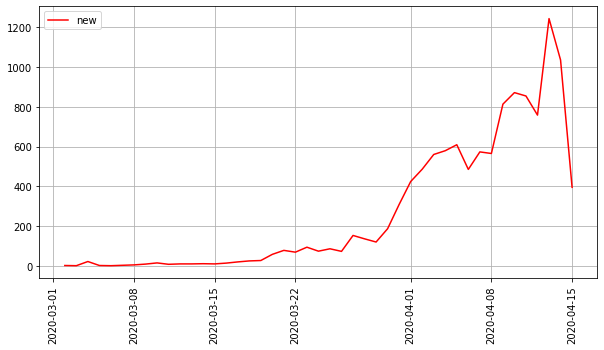

In [162]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
ax.plot(new_case_count['new'][3:], label = 'new', color = 'red')
# ax.plot(new_case_count['cum'][3:], label = 'total cases')

# plt.bar(new_case_count.index[3:], new_case_count['cum'][3:], label = 'total cases', color = 'yellow')

plt.xticks(rotation='vertical')
# plt.xlabel('dates')
plt.legend()
plt.grid()
plt.show()

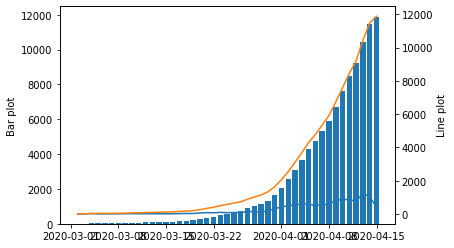

In [163]:
plt.figure()          
N = new_case_count.shape[0]-3

plt.bar(new_case_count.index[3:], new_case_count['cum'][3:], label = 'total cases')
plt.ylabel('Bar plot')      

axes2 = plt.twinx()
axes2.plot(new_case_count['new'][3:], label = 'new')
axes2.plot(new_case_count['cum'][3:], label = 'total cases')
# axes2.set_ylim(-1, 1)
axes2.set_ylabel('Line plot')

plt.show()

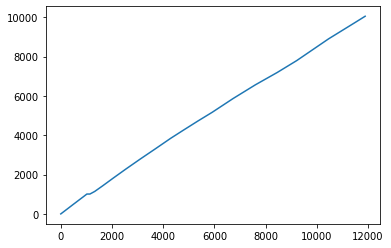

In [168]:
plt.plot(new_case_count['cum'], new_case_count['active_till_date'])

## Misc

In [33]:
arr = list(map(int, input("Enter Array : ").split()))
n = len(arr) 
LIS = [1 for i in range(n)] 
length = 0

# Find Longest Increasing Subseq and done 
for i in range(1, n): 
    for j in range(i): 
        if (arr[i]>arr[j] and (i-j)<=(arr[i]-arr[j]) and arr[i]>i and arr[j]>j): 
            LIS[i] = max(LIS[i], LIS[j] + 1) 
            
    length = max(length, LIS[i])
print(n - length)

Enter Array : 1 2 3 1
1


In [131]:
raw[:1]


,patientnumber,statepatientnumber,dateannounced,agebracket,gender,detectedcity,detecteddistrict,detectedstate,statecode,currentstatus,notes,contractedfromwhichpatientsuspected,nationality,typeoftransmission,statuschangedate,source1,source2,source3,backupnotes,estimatedonsetdate
0,1,KL-TS-P1,30/01/2020,20,F,Thrissur,Thrissur,Kerala,KL,Recovered,Travelled from Wuhan,NaN,India,Imported,14/02/2020,https://twitter.com/vijayanpinarayi/status/122...,https://weather.com/en-IN/india/news/news/2020...,NaN,Student from Wuhan,NaN


In [133]:
raw.shape

(11040, 20)

In [148]:
raw['statecode'].value_counts(dropna = False)

MH     2455
DL     1510
TN     1173
RJ      945
GJ      617
MP      614
TG      592
UP      558
AP      473
KL      378
NaN     289
JK      269
KA      258
HR      196
WB      190
PB      176
BR       66
OR       56
UT       35
HP       32
AS       31
CT       31
JH       24
CH       21
LA       17
AN       11
GA        7
PY        7
TR        2
MN        2
AR        1
NL        1
MZ        1
ML        1
DN        1
Name: statecode, dtype: int64

In [140]:
new_case_count[-1:]

,new,cum,rec,p,rec_cum,dead,dead_cum,active_till_date
2020-04-14,298,10753,28,1226,1226,2,360,9167


## ECDC Data

In [75]:
ecdc = "https://opendata.ecdc.europa.eu/covid19/casedistribution/csv"
ecdc_file = wget.download(ecdc)
ecdc_file

100% [............................................................................] 572794 / 572794

'csv'

In [126]:
ecdc_df = pd.read_csv(ecdc_file)

In [127]:
ecdc_df.head(2)

,dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2018
0,16/04/2020,16,4,2020,70,2,Afghanistan,AF,AFG,37172386.0
1,15/04/2020,15,4,2020,49,2,Afghanistan,AF,AFG,37172386.0


In [128]:
ecdc_df['dateRep'] = ecdc_df['dateRep'].apply(lambda x : datetime.strptime(x, "%d/%m/%Y"))

In [129]:
def curate(ecdc_df, geoID):
    
    in_ecdc = ecdc_df[ecdc_df['geoId'] == geoID].sort_values(by = 'dateRep')
    in_ecdc['cumCase'] = in_ecdc['cases'].cumsum()
    in_ecdc['cumDeath'] = in_ecdc['deaths'].cumsum()
    return in_ecdc

def func(ecdc_df, geoID):
    
    in_ecdc = curate(ecdc_df, geoID)
    plt.plot([i for i in range(len(in_ecdc['cumCase']))], in_ecdc['cumCase'], label = "cumCase")
    plt.plot([i for i in range(len(in_ecdc['cumDeath']))], in_ecdc['cumDeath'], label = "cumDeath")
    plt.grid(True)
    plt.legend()
    print(in_ecdc.head(2))

        dateRep  day  month  year  cases  deaths countriesAndTerritories  \
4826 2019-12-31   31     12  2019      0       0                   India   
4825 2020-01-01    1      1  2020      0       0                   India   

     geoId countryterritoryCode   popData2018  cumCase  cumDeath  
4826    IN                  IND  1.352617e+09        0         0  
4825    IN                  IND  1.352617e+09        0         0  


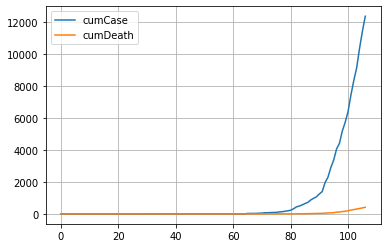

In [130]:
func(ecdc_df, "IN")